Optimizing E-Commerce Pricing with Predictive Analytics

In [468]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [469]:
df = pd.read_csv("ecomm.csv")

In [470]:
df

,User_ID,Product_ID,Category,Price (Rs.),Discount (%),Final_Price(Rs.),Payment_Method,Purchase_Date
0,337c166f,f414122f-e,Sports,36.53,15,31.05,Net Banking,12-11-2024
1,d38a19bf,fde50f9c-5,Clothing,232.79,20,186.23,Net Banking,09-02-2024
2,d7f5f0b0,0d96fc90-3,Sports,317.02,25,237.76,Credit Card,01-09-2024
3,395d4994,964fc44b-d,Toys,173.19,25,129.89,UPI,01-04-2024
4,a83c145c,d70e2fc6-e,Beauty,244.80,20,195.84,Net Banking,27-09-2024
...,...,...,...,...,...,...,...,...
3655,67abda0a,28714133-6,Beauty,486.79,0,486.79,UPI,14-05-2024
3656,34ebc1a0,08838c2c-9,Toys,212.87,15,180.94,Cash on Delivery,19-11-2024
3657,1defd3b1,c39a4f16-6,Home & Kitchen,389.76,0,389.76,Net Banking,07-08-2024
3658,0611293d,b4f67f96-9,Electronics,447.66,30,313.36,UPI,21-05-2024


In [471]:
# Check for non-numeric columns
print("\nCategorical columns:")
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric)

# Calculate the correlation matrix using only numeric columns
corr_matrix = df.corr(numeric_only=True) 
print("\nCorrelation Matrix:")
print(corr_matrix)


Categorical columns:
['User_ID', 'Product_ID', 'Category', 'Payment_Method', 'Purchase_Date']

Correlation Matrix:
                  Price (Rs.)  Discount (%)  Final_Price(Rs.)
Price (Rs.)          1.000000     -0.003473          0.935691
Discount (%)        -0.003473      1.000000         -0.311515
Final_Price(Rs.)     0.935691     -0.311515          1.000000


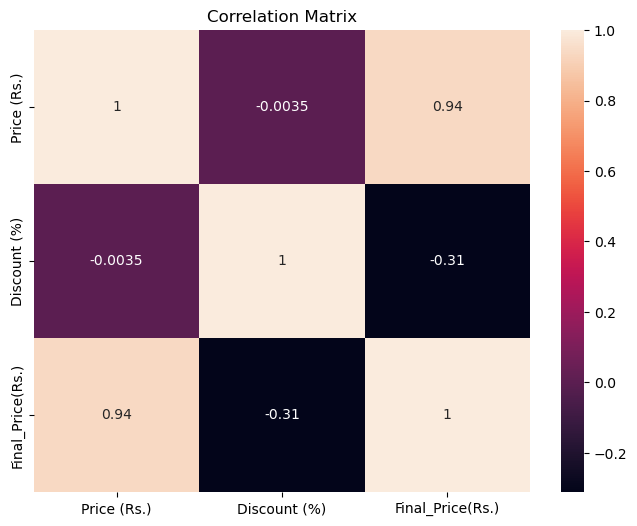

In [472]:
# Correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

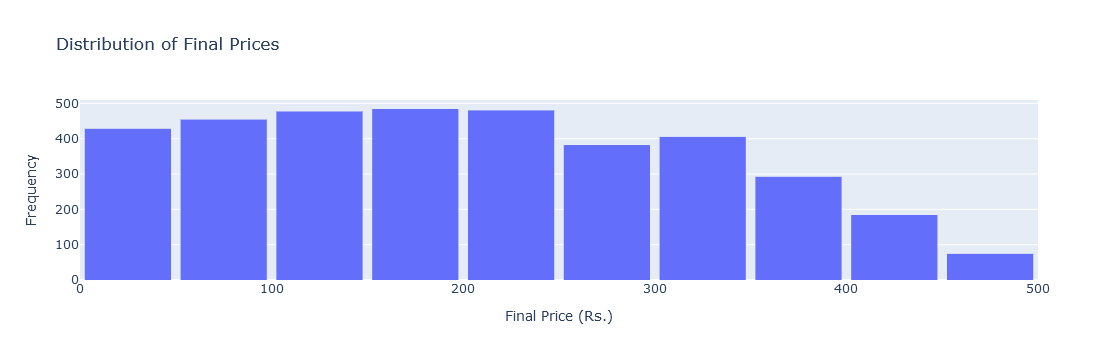

In [473]:
# Create a histogram to visualize the distribution of final prices
fig = px.histogram(df, x='Final_Price(Rs.)', nbins=20, title='Distribution of Final Prices')

# Update axis labels
fig.update_layout(
    xaxis_title='Final Price (Rs.)',
    yaxis_title='Frequency',
    bargap=0.1  # Set the gap between bars
)

# Show the plot
fig.show()

In [474]:
# Calculate the skewness of the 'Final_Price(Rs.)' column
skewness = df['Final_Price(Rs.)'].skew()

print("Skewness of Final Prices:", skewness)


Skewness of Final Prices: 0.23760411981835936


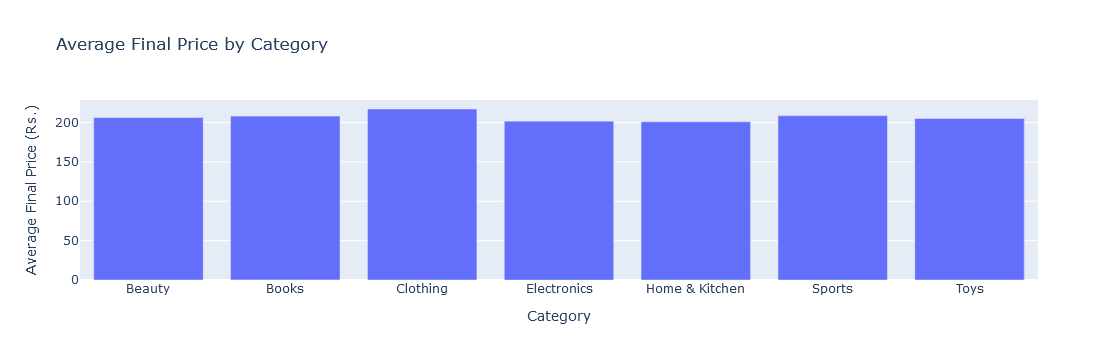

In [475]:
# Calculate the average final price by category
avg_price_by_category = df.groupby('Category')['Final_Price(Rs.)'].mean().reset_index()

# Create the bar plot using Plotly, with the original 'Category' names on the x-axis
fig = px.bar(avg_price_by_category, x='Category', y='Final_Price(Rs.)', title='Average Final Price by Category')

# Update axis labels
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Average Final Price (Rs.)',
)

# Show the plot
fig.show()

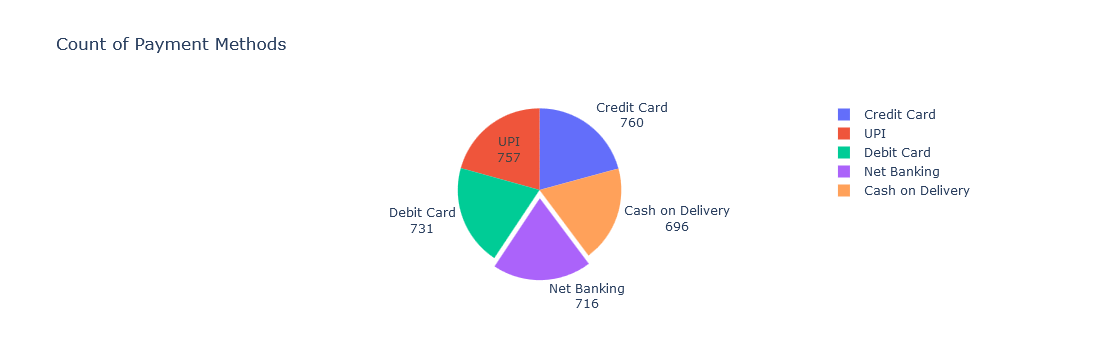

In [476]:
# Create a pie chart 
fig = px.pie(df, names='Payment_Method', title='Count of Payment Methods')

# Update the pie chart to show the actual count of each category
fig.update_traces(textinfo='label+value', pull=[0.1, 0, 0])  

# Show the plot
fig.show()

In [477]:
# Convert Purchase_Date to datetime format
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], format='%d-%m-%Y')

# Create a new feature: Price after Discount
df['Discounted_Amount(Rs.)'] = df['Price (Rs.)'] * (df['Discount (%)'] / 100)
df['Price_After_Discount(Rs.)'] = df['Price (Rs.)'] - df['Discounted_Amount(Rs.)']

# Create a feature for the month of purchase
df['Purchase_Month'] = df['Purchase_Date'].dt.month

# Display the updated DataFrame with new features
print("\nDataFrame with New Features:")
print(df.head())


DataFrame with New Features:
    User_ID  Product_ID  Category  Price (Rs.)  Discount (%)  \
0  337c166f  f414122f-e    Sports        36.53            15   
1  d38a19bf  fde50f9c-5  Clothing       232.79            20   
2  d7f5f0b0  0d96fc90-3    Sports       317.02            25   
3  395d4994  964fc44b-d      Toys       173.19            25   
4  a83c145c  d70e2fc6-e    Beauty       244.80            20   

   Final_Price(Rs.) Payment_Method Purchase_Date  Discounted_Amount(Rs.)  \
0             31.05    Net Banking    2024-11-12                  5.4795   
1            186.23    Net Banking    2024-02-09                 46.5580   
2            237.76    Credit Card    2024-09-01                 79.2550   
3            129.89            UPI    2024-04-01                 43.2975   
4            195.84    Net Banking    2024-09-27                 48.9600   

   Price_After_Discount(Rs.)  Purchase_Month  
0                    31.0505              11  
1                   186.2320      

In [478]:
# Initialize an empty dictionary to store label encoders
label_encoders = {}

# List of categorical columns to encode
categorical_cols = ['Category', 'Payment_Method']

# Encoding categorical variables
for col in categorical_cols:
    le = LabelEncoder()  # Initialize the LabelEncoder
    df[col] = le.fit_transform(df[col])  # Apply the encoding
    label_encoders[col] = le  # Store the encoder for future use

    # Print the encoded values (original categories) and corresponding numbers
    print(f"\nEncoding for column: {col}")
    for category, encoded_value in zip(le.classes_, range(len(le.classes_))):
        print(f"{category} -> {encoded_value}")

# Print the DataFrame after encoding
print("\nDataFrame after Label Encoding:")
print(df.head())


Encoding for column: Category
Beauty -> 0
Books -> 1
Clothing -> 2
Electronics -> 3
Home & Kitchen -> 4
Sports -> 5
Toys -> 6

Encoding for column: Payment_Method
Cash on Delivery -> 0
Credit Card -> 1
Debit Card -> 2
Net Banking -> 3
UPI -> 4

DataFrame after Label Encoding:
    User_ID  Product_ID  Category  Price (Rs.)  Discount (%)  \
0  337c166f  f414122f-e         5        36.53            15   
1  d38a19bf  fde50f9c-5         2       232.79            20   
2  d7f5f0b0  0d96fc90-3         5       317.02            25   
3  395d4994  964fc44b-d         6       173.19            25   
4  a83c145c  d70e2fc6-e         0       244.80            20   

   Final_Price(Rs.)  Payment_Method Purchase_Date  Discounted_Amount(Rs.)  \
0             31.05               3    2024-11-12                  5.4795   
1            186.23               3    2024-02-09                 46.5580   
2            237.76               1    2024-09-01                 79.2550   
3            129.89          

In [479]:
#Splitting data
# Features and target variable
X = df[['Price (Rs.)', 'Discount (%)', 'Category', 'Payment_Method']]
y = df['Final_Price(Rs.)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Model coefficients: [ 0.81554307 -2.56952402  0.25732136 -0.05422413]


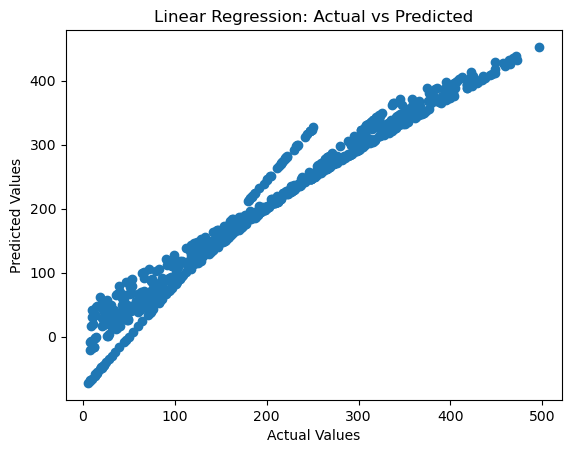

In [480]:
# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

# Print model coefficients
print("Model coefficients:", model.coef_)

# Plot the predictions vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()


In [481]:
# Make predictions
y_pred = model.predict(X_test)

In [482]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Display coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)


Model Evaluation:
Mean Squared Error: 511.50
R^2 Score: 0.96

Model Coefficients:
                Coefficient
Price (Rs.)        0.815543
Discount (%)      -2.569524
Category           0.257321
Payment_Method    -0.054224


In [483]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree MSE: {mse_dt:.2f}, R^2 Score: {r2_dt:.2f}")


Decision Tree MSE: 2.43, R^2 Score: 1.00


In [484]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the model performance
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model MSE: {mse_best:.2f}, R^2 Score: {r2_best:.2f}")


Best Model MSE: 2.44, R^2 Score: 1.00


In [485]:
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")

Cross-Validation Scores: [0.96847901 0.97036659 0.96788955 0.97193011 0.9730805 ]
Mean CV Score: 0.97


In [486]:
adj_r2 = 1 - (1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print(f"Adjusted R²: {adj_r2:.2f}")

Adjusted R²: 0.96
